In [1]:
# last updated date: 2/25/2025
# Breast cancer data vizualization

In [17]:
import numpy as np
import pandas as pd
import pickle
import random
import timeit
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
from matplotlib import pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from breast_cancer_prob_two import BreastCancerProblem

np.random.seed(42)
random.seed(42)

# Set pandas options to display all rows and columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Disable line wrapping
pd.set_option("display.max_colwidth", None)  # Disable truncation for column width


def process_data(file_name, class_label):
    # read the data
    data = pd.read_csv(file_name)
    # replace 'M' with 0 and 'B' with 1
    data["Diagnosis"] = data["Diagnosis"].replace({"M": 0, "B": 1})

    # select the target class and keep that column separately
    target_class = data[class_label]

    # drop the target class from the data
    data_wo_label = data.drop(columns=[class_label])

    col_list = data_wo_label.columns.to_list()
    min_values = data_wo_label[col_list].min()
    max_values = data_wo_label[col_list].max()

    return data_wo_label, target_class, min_values, max_values


def train_and_save_model(data_wo_label, target_class, model_filename):

    X = data_wo_label
    y = target_class
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # standardize the numerical features before training the model - use select_dtypes to detect numerical features
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
    # print("numerical_features", numerical_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
        ]
    )

    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", MLPClassifier(random_state=42)),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # save the trained model
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved as {model_filename}")


def load_model(model_filename, data_wo_label, target_class):
    # check if the model file exists
    if os.path.exists(model_filename):
        # load the existing model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model loaded from existing file, {model_filename}")
    else:
        print(f"Model file {model_filename} is missing.")
        # if the model file is missing, train and save a new model
        train_and_save_model(data_wo_label, target_class, model_filename)
        # reload the newly saved model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model reloaded from {model_filename}")

    return loaded_model


In [18]:
file_name = "breast_cancer.csv"
extracted_data_name = file_name.split(".")[0]
class_label = "Diagnosis"
data_wo_label, target_class, min_values, max_values = process_data(
    file_name, class_label
)

model_filename = "breast_cancer_model.pkl"
loaded_model = load_model(model_filename, data_wo_label, target_class)

combined_data = pd.concat([data_wo_label, target_class], axis=1)

# select 10 malignant samples from the data (0 is malignant)
m_samples = combined_data[combined_data["Diagnosis"] == 0].sample(
     n=10, random_state=42
 )
m_samples = m_samples.drop(columns=["Diagnosis"])  # drop the target variable
#print("benign sample list", b_samples)

#for idx in b_samples.index:
    #b_sample = b_samples.loc[idx]
idx = 56
m_sample = m_samples.loc[idx]
#print(f"benign sample index {idx}:", b_sample)



Model loaded from existing file, breast_cancer_model.pkl


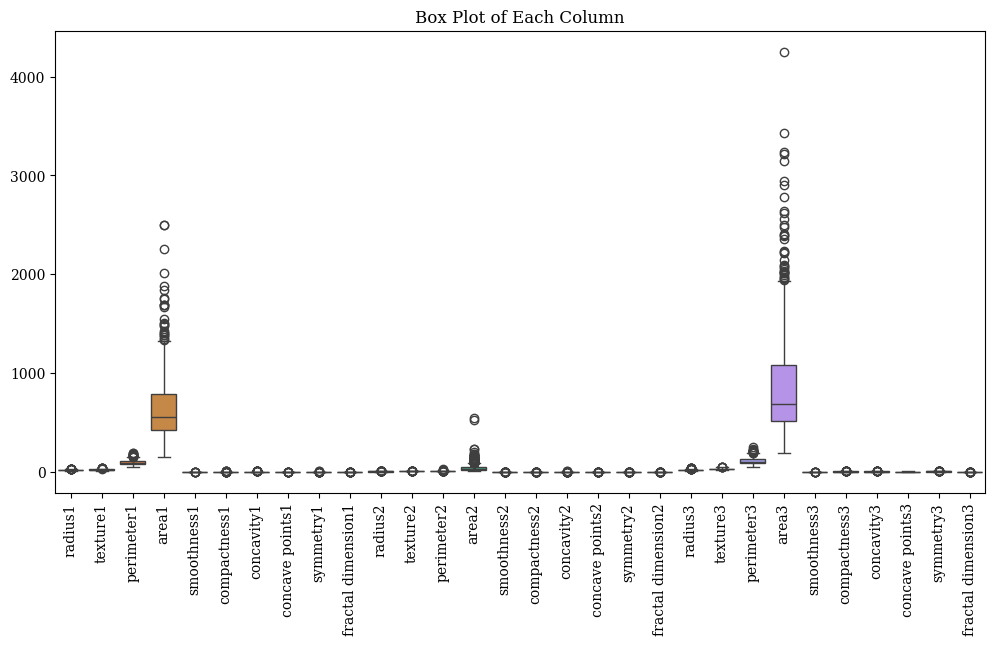

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_wo_label)
plt.xticks(rotation=90)
plt.title("Box Plot of Each Column")
plt.show()

# note the ranges for area1, area2, and area3

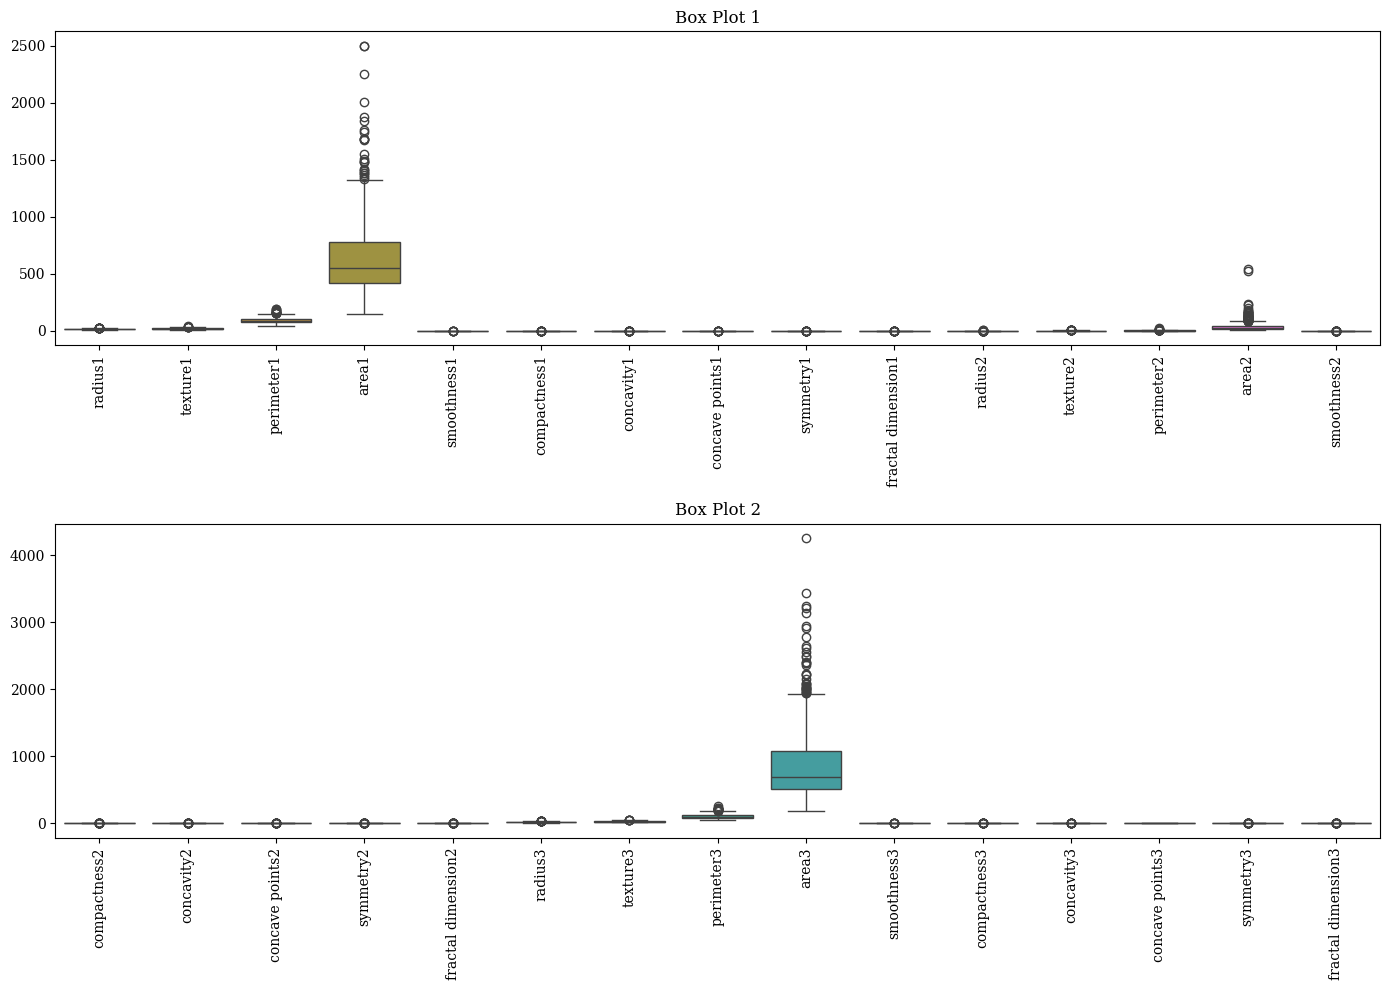

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Split columns into two halves
num_cols = data_wo_label.select_dtypes(include=np.number).columns
mid = len(num_cols) // 2
cols1, cols2 = num_cols[:mid], num_cols[mid:]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))  # 1 row, 2 columns

# First half
sns.boxplot(data=data_wo_label[cols1], ax=axes[0])
axes[0].set_title("Box Plot 1")
axes[0].tick_params(axis='x', rotation=90)

# Second half
sns.boxplot(data=data_wo_label[cols2], ax=axes[1])
axes[1].set_title("Box Plot 2")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout() 
plt.show()

In [4]:

def save_hist_FX(
    hist_F, hist_X, extracted_data_name, pop_size, sample_idx, data_wo_label
):
    # save column names
    col_list = data_wo_label.columns.to_list()
    # Process hist_F and hist_X to save in a .csv file
    data = []
    f1_values = []
    f2_values = []
    for f_arr, x_list in zip(hist_F, hist_X):
        for f, x in zip(f_arr, x_list):
            # create a dictionary to map the x values to each column name
            x_dict = dict(zip(col_list, x))
            # Flatten and combine F and X values
            row = {"F1": f[0], "F2": f[1], "X": x_dict}
            data.append(row)

            # Save the f1 and f2 values for plotting
            f1_values.append(f[0])
            f2_values.append(f[1])

    # Convert to df
    df = pd.DataFrame(data)
    print("shape of history: ", df.shape)
    print(df.head())
    

In [5]:
problem = BreastCancerProblem(
    loaded_model,
    original_sample=m_sample,
    sample_idx=idx,
    desired_class=1,  # 1 is benign
    min_values=min_values,
    max_values=max_values,
)

# set the population size
pop_size = 100

# initialize the algorithm
algorithm = NSGA2(pop_size=pop_size)



In [6]:
# run the optimization
res = minimize(
    problem, algorithm, ("n_gen", 100), seed=1, save_history=True, verbose=False
)

for f1, f2 in zip(problem.all_f1, problem.all_f2):
    print(f"f1: {f1}, f2: {f2}") 


f1: 0.9999999999940082, f2: 0.40516223728625694
f1: 1.0, f2: 0.4002909384697192
f1: 1.0, f2: 0.24898287410195924
f1: 0.9999999965510754, f2: 0.3900041725555166
f1: 0.9998572047364419, f2: 0.651779458939254
f1: 0.9999999988453138, f2: 0.30219703125661906
f1: 0.999999999801363, f2: 0.4652287898656971
f1: 0.9999972517069395, f2: 0.46631398445937927
f1: 0.9999999999997721, f2: 0.47193928131174734
f1: 0.9999999994891042, f2: 0.0
f1: 0.9999985551622561, f2: 0.6730523256233876
f1: 1.0, f2: 0.41578683437875597
f1: 0.9999999999999957, f2: 0.5029804460747394
f1: 0.9999999999999994, f2: 0.5547121123565707
f1: 0.999999999142495, f2: 0.91997153433646
f1: 0.9999999999999994, f2: 0.5609812053393884
f1: 0.9999999942964362, f2: 0.588863991865812
f1: 1.0, f2: 0.5535078010664821
f1: 0.9999999999989271, f2: 0.8228544184872002
f1: 0.9999999999740565, f2: 0.49363173454948484
f1: 0.9999999916497451, f2: 0.3345532583844568
f1: 0.9999999999850148, f2: 0.6534699816072628
f1: 0.9999999999995582, f2: 0.5414883524

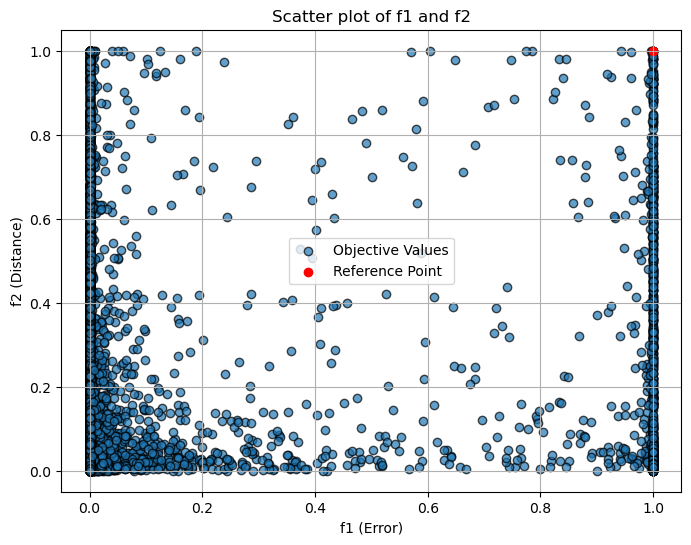

In [7]:
# create the scatter plot for all f1 and f2
plt.figure(figsize=(8, 6))
plt.scatter(
    problem.all_f1,
    problem.all_f2,
    alpha=0.7,
    edgecolors="k",
    label="Objective Values",
)
plt.scatter(
    problem.max_error, problem.max_distance, color="red", label="Reference Point"
)
plt.title("Scatter plot of f1 and f2")
plt.xlabel("f1 (Error)")
plt.ylabel("f2 (Distance)")
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.5))
plt.grid(True)

plt.show()

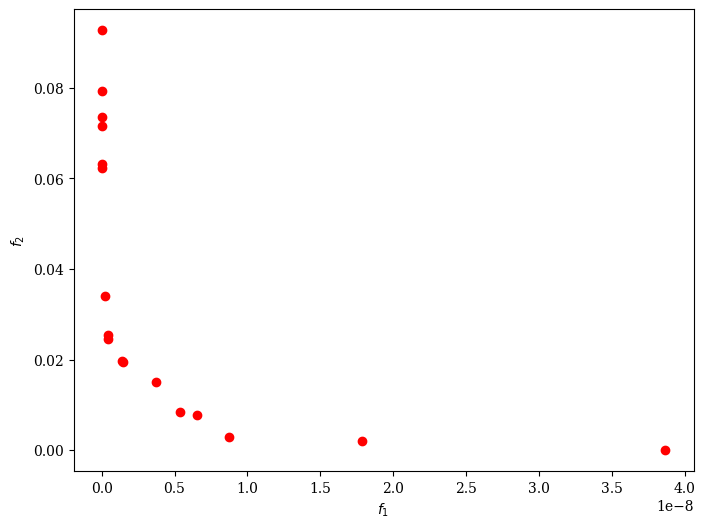

In [8]:
# create a scatter plot of the Pareto front
plot = Scatter()
plot.add(res.F, color="red")

# display the plot
plot.show()

In [9]:
# save the dots
pareto_front = res.F
pareto_front_df = pd.DataFrame(pareto_front, columns=["Error", "Distance"])
print(pareto_front_df)


           Error  Distance
0   1.456583e-11  0.063224
1   3.706636e-09  0.014986
2   1.478482e-09  0.019483
3   4.409605e-10  0.025555
4   2.770793e-12  0.073628
5   2.211379e-10  0.034095
6   2.304162e-12  0.079282
7   5.095251e-11  0.062302
8   1.400253e-09  0.019818
9   4.426066e-10  0.024559
10  3.573580e-12  0.071510
11  3.867798e-08  0.000000
12  0.000000e+00  0.092689
13  8.740066e-09  0.002995
14  6.541753e-09  0.007874
15  1.788788e-08  0.001999
16  5.353955e-09  0.008561


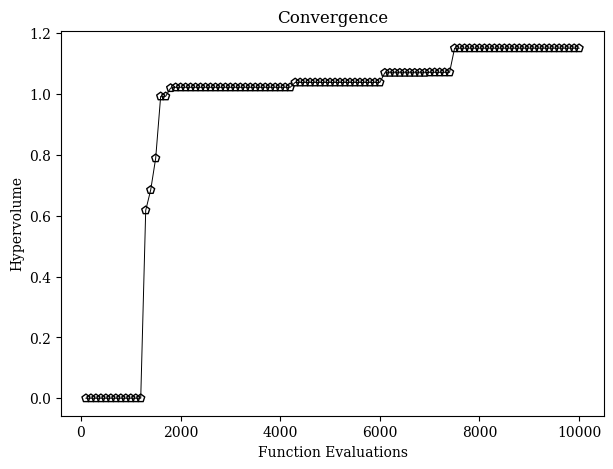

In [10]:

hist = res.history

n_evals = []  # number of evaluations
hist_F = []  # objective space values in each generation
hist_X = []  # design variable values in each generation

for algo in hist:
    n_evals.append(algo.evaluator.n_eval)
    opt = algo.opt
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(algo.opt.get("F")[feas])
    hist_X.append(algo.opt.get("X")[feas])

# hypervolume (HV)
approx_ideal = res.F.min(axis=0)
approx_nadir = res.F.max(axis=0)

buffer = 0.1
ref_point = np.array([problem.max_error + buffer, problem.max_distance + buffer])
metric = Hypervolume(
    ref_point=ref_point,
    norm_ref_point=False,
    zero_to_one=True,
    ideal=approx_ideal,
    nadir=approx_nadir,
)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv, color="black", lw=0.7, label="Hypervolume Over Generations")
plt.scatter(n_evals, hv, facecolor="none", edgecolor="black", marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()


In [11]:
# save the hypervolume values to a file
hv_df = pd.DataFrame(hv)
print("Hypervolume values: ")
print(hv_df)


Hypervolume values: 
           0
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.000000
5   0.000000
6   0.000000
7   0.000000
8   0.000000
9   0.000000
10  0.000000
11  0.000000
12  0.618162
13  0.684994
14  0.789327
15  0.992869
16  0.992869
17  1.020204
18  1.022528
19  1.022528
20  1.022528
21  1.022528
22  1.022528
23  1.022528
24  1.022528
25  1.022528
26  1.022528
27  1.022528
28  1.022528
29  1.022528
30  1.022528
31  1.022528
32  1.022528
33  1.022528
34  1.022528
35  1.022528
36  1.022528
37  1.022528
38  1.022528
39  1.022528
40  1.022528
41  1.022528
42  1.038696
43  1.038696
44  1.038696
45  1.038696
46  1.038696
47  1.038696
48  1.038696
49  1.038696
50  1.038696
51  1.038696
52  1.038696
53  1.038696
54  1.038696
55  1.038696
56  1.038696
57  1.038696
58  1.038696
59  1.038702
60  1.070533
61  1.070533
62  1.070533
63  1.070533
64  1.070533
65  1.070533
66  1.070533
67  1.070533
68  1.070533
69  1.071813
70  1.071813
71  1.071813
72  1.071813
73  1.071813
74  

In [12]:
def log_results(genomes, m_sample, data_wo_label):
    col_list = data_wo_label.columns.to_list()
    # display the original benign sample
    val_dict = dict(zip(col_list, m_sample))
    print("Malignant sample: ")
    print(f"{val_dict},\n")

    # log the generated counterfactuals
    print("Generated counterfactuals: ")
    for i, genome in enumerate(genomes):
        genome_dict = dict(zip(col_list, genome))

        print(f"{i+1}: {genome_dict},\n")



In [15]:

log_results(problem.all_genomes, m_sample, data_wo_label)


Malignant sample: 
{'radius1': 19.21, 'texture1': 18.57, 'perimeter1': 125.5, 'area1': 1152.0, 'smoothness1': 0.1053, 'compactness1': 0.1267, 'concavity1': 0.1323, 'concave points1': 0.08994, 'symmetry1': 0.1917, 'fractal dimension1': 0.05961, 'radius2': 0.7275, 'texture2': 1.193, 'perimeter2': 4.837, 'area2': 102.5, 'smoothness2': 0.006458, 'compactness2': 0.02306, 'concavity2': 0.02945, 'concave points2': 0.01538, 'symmetry2': 0.01852, 'fractal dimension2': 0.002608, 'radius3': 26.14, 'texture3': 28.14, 'perimeter3': 170.1, 'area3': 2145.0, 'smoothness3': 0.1624, 'compactness3': 0.3511, 'concavity3': 0.3879, 'concave points3': 0.2091, 'symmetry3': 0.3537, 'fractal dimension3': 0.08294},

Generated counterfactuals: 
1: {'radius1': 9.141, 'texture1': 15.189, 'perimeter1': 122.618, 'area1': 1152.786, 'smoothness1': 0.082, 'compactness1': 0.335, 'concavity1': 0.043, 'concave points1': 0.003, 'symmetry1': 0.198, 'fractal dimension1': 0.068, 'radius2': 0.316, 'texture2': 3.124, 'perimeter2

In [16]:

save_hist_FX(hist_F, hist_X, extracted_data_name, pop_size, idx, data_wo_label)


shape of history:  (1453, 3)
         F1        F2  \
0  1.000000  0.000000   
1  0.932096  0.600992   
2  0.000000  0.833526   
3  0.999620  0.052704   
4  1.000000  0.000000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    